# Would Rose survive and Jack die in real life?
In the box office smash hit film *Titanic*, Rose and Jack's brief romance is interrupted by an annoying iceberg utterly tone deaf to early 20th century courtship practices. Although unlikely to have met in real life - Rose being a sophisticated upperclass 17-year-old woman traveling with her mother and fiance and Jack being a charming 20-year-old lowerclass ne'er-do-well who won tickets to the golden land with his friend in a poker game - we as an audience are asked to suspend our disbelief for a brief interlude of "movie magic".

To make an exceedingly long story short, Rose survives and Jack dies. The question I seek to answer is how realisitic is this outcome? To answer that we will use a little bit of machine learning...

## Import required modules

In [106]:
# Modules for handling and processing data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_curve, auc

# Modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read in the data

In [68]:
dataset = pd.read_csv('titanic-data.csv')
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [69]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Modify dataset

I will remove a few columns since they do not relate to our question or we never learn from the film. Goodbye PassengerId, Name, Ticket, Cabin, and Fare.

I will also move out of dataframes and into matrices.

In [70]:
columns_to_keep = ~dataset.columns.isin(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'])
dataset = dataset.loc[:, columns_to_keep]
dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


That looks much better.

## Fill in missing values

We see that a bunch of ages are missing and a couple embarkation points. We will fill the missing ages with the median age and the embarkation points with the most frequent entry (the mode).

In [71]:
dataset.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Embarked      2
dtype: int64

In [78]:
dataset.loc[dataset['Age'].isnull(), 'Age'] = dataset['Age'].median()
dataset.loc[dataset['Embarked'].isnull(), 'Embarked'] = dataset['Embarked'].mode()[0]

dataset.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
dtype: int64

## Label encode our categorical variables

In [79]:
sex_encoder = LabelEncoder()
embark_encoder = LabelEncoder()

dataset['Sex'] = sex_encoder.fit_transform(dataset['Sex'].values)
dataset['Embarked'] = embark_encoder.fit_transform(dataset['Embarked'].values)

dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,1,22.0,1,0,2
1,1,1,0,38.0,1,0,0
2,1,3,0,26.0,0,0,2
3,1,1,0,35.0,1,0,2
4,0,3,1,35.0,0,0,2


We need to encode our categorical variables represented by strings (Sex and Embarked) into numbers.

In [80]:
sex_encoder.classes_

array(['female', 'male'], dtype=object)

In [81]:
embark_encoder.classes_

array(['C', 'Q', 'S'], dtype=object)

Now that we have everything encoded, we can make arrays representing Rose and Jack

In [118]:
Rose = np.array([[1, 0, 17, 0, 1, 2]])
Jack = np.array([[3, 1, 20, 0, 0, 2]])

We also might as well save this transformed dataset for tableau

In [138]:
dataset.to_csv('Processed_titanic_data.csv')

## Should we split Age into groups?

It would be much easier for classification if we could convert Age into a class variable (perhaps children, teenagers, and adults) as opposed to numbers. Let's see if there is an obvious split in ages amongst the passengers.

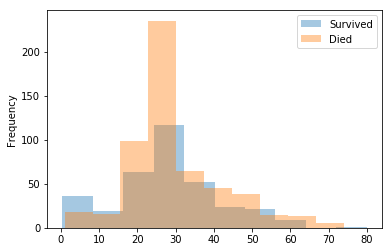

In [103]:
dataset.loc[dataset.Survived == 1, 'Age'].plot(kind='hist', alpha=.4, label='Survived');
dataset.loc[dataset.Survived == 0, 'Age'].plot(kind='hist', alpha=.4, label='Died');
plt.legend();

## Splitting our data into train/test groups

We need to split out dataset into training and testing groups to make sure we are not overfitting our model

In [91]:
X = dataset.iloc[:, 1:].values
Y = dataset.iloc[:, 0].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

X_train

array([[ 3.,  0., 28.,  0.,  2.,  0.],
       [ 2.,  1., 31.,  0.,  0.,  2.],
       [ 2.,  1., 31.,  1.,  1.,  0.],
       ...,
       [ 3.,  1., 28.,  0.,  0.,  1.],
       [ 3.,  0., 36.,  1.,  0.,  2.],
       [ 2.,  1., 60.,  1.,  1.,  2.]])

## Build our decision tree!

In [110]:
clf = DecisionTreeClassifier(random_state=1)

cvs = cross_val_score(clf, X, Y, cv=5)
print(cvs)

[0.74860335 0.79888268 0.80898876 0.80337079 0.81920904]


In [121]:
## Fit the model with data
clf.fit(X_train, Y_train)
## Accuracy with our training data
acc_decision_tree = round(clf.score(X_test, Y_test), 4)
print("Accuracy: %0.4f" % (acc_decision_tree))

Accuracy: 0.8045


In [123]:
## Predict y given validation set
predictions = clf.predict(X_test)

## Take a look at the confusion matrix ([TN,FN],[FP,TP])
confusion_matrix(Y_test, predictions)

## Precision
print("Precision: %0.4f" % precision_score(Y_test, predictions))
## Recall score
print("Recall: %0.4f" % recall_score(Y_test, predictions))
## Print classification report
print(classification_report(Y_test, predictions))

Precision: 0.7833
Recall: 0.6812
             precision    recall  f1-score   support

          0       0.82      0.88      0.85       110
          1       0.78      0.68      0.73        69

avg / total       0.80      0.80      0.80       179



In [137]:
survive_list = ['No', 'Yes']
ourlovers = [clf.predict(Rose)[0], clf.predict(Jack)[0]]
movie_outcome = [1, 0]
print("Would Rose survive according to our model? Our prediction is %s" % survive_list[clf.predict(Rose)[0]])
print("Would Jack survive according to our model? Our prediction is %s" % survive_list[clf.predict(Jack)[0]])
print("Was the movie accurate? Our model says %s" % str(movie_outcome == ourlovers))

Would Rose survive according to our model? Our prediction is Yes
Would Jack survive according to our model? Our prediction is No
Was the movie accurate? Our model says True


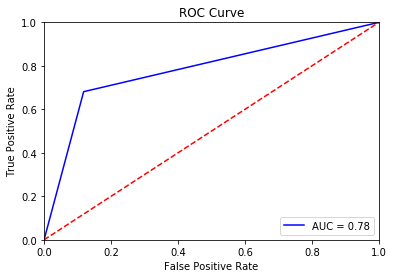

In [129]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(Y_test, predictions)
roc_auc = auc(fp, tp)


# In[54]:

## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()